In [1]:
# import stuff
import os
import numpy as np
import matplotlib.pyplot as plt
from uncertainty_motion_prediction.dataloader import Dataloader
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
from uncertainty_motion_prediction.visualizer import SamplingVisualizer, visualize_covariance_to_axis
from uncertainty_motion_prediction.predictor.hmm_latent_segments import (
    segmentize_trajectory, normalise_segment, normalise_segment_batch
)

In [2]:
dataset=Dataloader();
dataset_index = 0
traj_dataset = dataset.load(dataset_index)

## As numpy array

In [3]:
trajlets = traj_dataset.get_trajlets(length=4.8, to_numpy=True)
trajlets[0, :, :]

array([[13.017548  ,  5.7825914 , -2.3244442 , -0.07660594, 53.6       ],
       [12.08777   ,  5.751949  , -1.5890517 , -0.06597106, 54.        ],
       [11.746306  ,  5.7298146 , -1.1407656 ,  0.10537256, 54.4       ],
       [11.175158  ,  5.8362471 , -1.6400209 ,  0.17923528, 54.8       ],
       [10.43429   ,  5.8732028 , -1.4061292 ,  0.41904965, 55.2       ],
       [10.050254  ,  6.1714868 , -1.0787423 ,  0.45518986, 55.6       ],
       [ 9.5712958 ,  6.2373547 , -1.207725  ,  0.11543663, 56.        ],
       [ 9.0840742 ,  6.2638361 , -1.2731811 ,  0.17084078, 56.4       ],
       [ 8.5527509 ,  6.3740273 , -1.2327335 ,  0.2715015 , 56.8       ],
       [ 8.0978874 ,  6.4810373 , -1.1467297 ,  0.21789191, 57.2       ],
       [ 7.6353672 ,  6.5483408 , -1.1634956 ,  0.16930578, 57.6       ],
       [ 7.1670909 ,  6.616482  , -1.1264929 ,  0.11639996, 58.        ]])

# Hidden Markov Model with trajectory sub-segment latent states

This method works by modelling a pedestrian trajectory as being composed of multiple common segment primitives. Developing the HMM model consists of 2 parts:
* Extracting common trajectory sub-segments from data. These sub-segments or segment primitives will be the states of the HMM.
* Learn the transition matrix of the HMM. To predict the pedestrian's trajectory, we need the ability to predict the next state or segment primitive the pedestrian will transit to after the current segment the pedestrian is executing.

## Sanity checks

We perform some sanity checks on artificial data first to validate the HMM algorithm. Generate the artificial trajectories from a set of 5 different trajectory types

In [3]:
seg_type1 = [[0, 0, 1, 0], [1, 0, 5, 0], [6, 0, 5, 0]]
seg_type2 = [[0, 0, 1, 0], [1, 0, 1, 0], [2, 0, 1, 0]]
seg_type3 = [[0, 0, 1, 0], [1, 0, 1, 1], [2, 1, 1, 1]]
seg_type4 = [[0, 0, 1, 0], [1, 0, 1, -1], [2, -1, 1, -1]]
seg_type5 = [[0, 0, 1, 0], [1, 0, -2, 0], [-1, 0, -2, 0]]

seg_types = np.array([seg_type1, seg_type2, seg_type3, seg_type4, seg_type5])
test_trajs = []

for seg_type in seg_types:
    for i in range(3):
        angle = np.random.uniform(-2*np.pi, 2*np.pi)
        scale = np.random.uniform(0.5, 1.5)
        trans = np.array([[np.random.uniform(-10, 10), np.random.uniform(-10, 10)]]).T

        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        S = np.array([[scale, 0], 
                      [0, scale]])

        seg = np.dot(S, np.dot(R, seg_type[:, 0:2].T))
        seg = seg + trans
        seg_vels = np.dot(S, np.dot(R, seg_type[:, 2:].T))
        sample = np.hstack((seg.T, seg_vels.T))
        test_trajs.append(sample)
        
# print(test_trajs)
print(np.array(test_trajs).shape)

(15, 3, 4)


Test the performance of the clustering step. The code implements 2 different ways to do this: 1) X-means which automatically selects the optimal number of clusters using Bayesian Information Criterion, 2) iterative K-means over a range of possible numbers of clusters, with the user left to select the optimal number of clusters manually from the extracted distance-to-centroid and silhouette methods.

We test (2), since the X-means approach with BIC seems prone to over-clustering.

Text(0.5, 1.0, 'Silhouette scores')

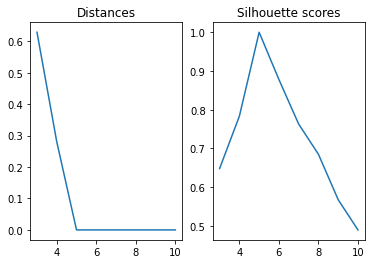

In [4]:
extractor = HMMLatentSegmentsExtractor(segment_len=3)

dists, silhouettes, clusters, centres = extractor.learn_latent_segments_manual_kmeans(np.array(test_trajs))
cluster_range = range(extractor._n_min_centres, extractor._n_max_centres + 1)

fig, axs = plt.subplots(1, 2)
axs[0].plot(cluster_range, dists)
axs[1].plot(cluster_range, silhouettes)
axs[0].set_title('Distances')
axs[1].set_title('Silhouette scores')

In [5]:
clustering_tmp = KMeansOutcome(3, centres[2])
clustering_tmp.save_to_file("./tmp_clustering.pickle")
clustering = KMeansOutcome.load_from_file("./tmp_clustering.pickle")
print(clustering.N)
clustering.classify_batch(test_trajs)

5


[2, 2, 2, 1, 1, 1, 3, 3, 3, 4, 4, 4, 0, 0, 0]

In [9]:
np.array(centres[2]).reshape([2, -1]).T

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.93712943e-01,  1.38860554e-18],
       [-1.93712943e-01,  5.55111512e-17],
       [ 0.00000000e+00,  0.00000000e+00],
       [-9.96894022e-18,  3.53553391e-01],
       [ 3.46944695e-17,  7.07106781e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 5.00000000e-01,  5.09614728e-18],
       [ 1.00000000e+00,  3.53553391e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 4.07560769e-17,  3.53553391e-01],
       [ 6.93889390e-18,  7.07106781e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.09611797e-01,  2.94021069e-17],
       [ 6.57670781e-01, -3.53553391e-01]])

## Learn segments from data

In [10]:
segment_length = 4
estimate_velocity = True
trajlets_for_segments_learning = traj_dataset.get_trajlets(length=segment_length*0.4, overlap=1, to_numpy=True)
print(trajlets_for_segments_learning.shape)

(3478, 4, 5)


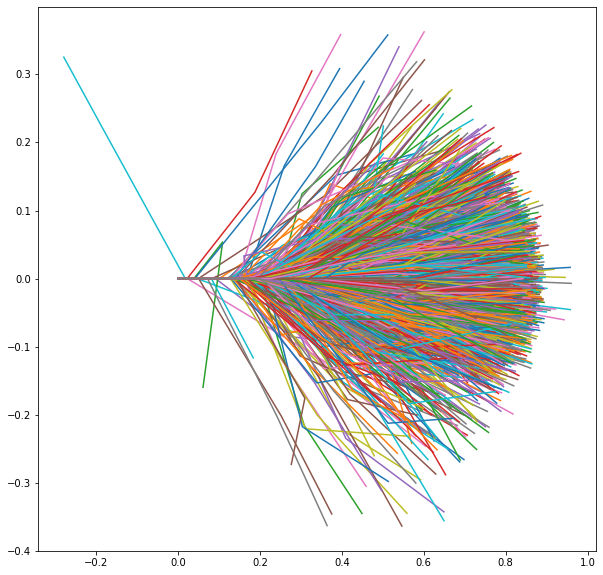

In [11]:
trajlets_for_segments_learning_normalized = normalise_segment_batch(
    trajlets_for_segments_learning, segment_length, estimate_vel=True
)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for p in trajlets_for_segments_learning_normalized:
    axs.plot(p[0:segment_length], p[segment_length:])

In [12]:
extractor = HMMLatentSegmentsExtractor(
    segment_len=segment_length, n_min_centres=30, n_max_centres=100, estimate_velocity=estimate_velocity
)
dists, silhouettes, clusters, centres = extractor.learn_latent_segments_manual_kmeans(
    trajlets_for_segments_learning[:, :, 0:4]
)
cluster_range = range(extractor._n_min_centres, extractor._n_max_centres + 1)

Text(0.5, 1.0, 'Silhouette scores')

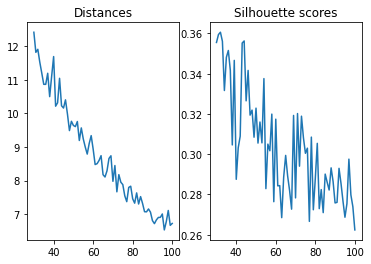

In [13]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(cluster_range, dists)
axs[1].plot(cluster_range, silhouettes)
axs[0].set_title('Distances')
axs[1].set_title('Silhouette scores')

In [15]:
center_idx = 30
print(dists[center_idx])
center = np.array(centres[center_idx])
clustering = KMeansOutcome(segment_length, center, estimate_velocity=estimate_velocity)
clustering.save_to_file("./hmm_segment_clustering_%d.pickle" %dataset_index)
print(clustering.N)

8.935760746850551
60


In [16]:
patterns = center.reshape([-1, 2, segment_length])
print(patterns.shape)

(60, 2, 4)


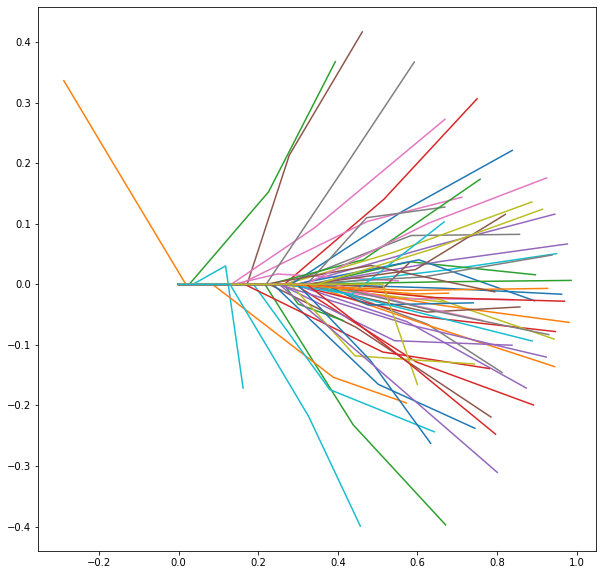

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for p in patterns[:, :, :]:
    axs.plot(p[0, :], p[1, :])

## Learn HMM model

In [19]:
segment_length = 4
num_segment = 10
clustering = KMeansOutcome.load_from_file("./hmm_segment_clustering_%d.pickle" %dataset_index)
assert clustering.segment_length == segment_length
traj_length = num_segment * (segment_length - 1) + 1
trajlets_for_hmm_learning = traj_dataset.get_trajlets(
    length= traj_length * 0.4, overlap=4, to_numpy=True
)
print(trajlets_for_hmm_learning.shape)

(54, 31, 5)


In [20]:
# print(trajlets_for_hmm_learning[0, 0:12, 0:4])
# print(trajlets_for_hmm_learning[0, 0:12, 0:4].reshape([3, 4, 4]))

In [21]:
observations = []
for t in trajlets_for_hmm_learning:
    segments = segmentize_trajectory(t, segment_length)
    obs = clustering.classify_batch(segments)
    observations.append(obs)

In [23]:
# observations

In [36]:
state_dim = 50
hmm = HMMMultinomialFirstOrder(state_dim, clustering.N, verbose=True, max_iters=30)
try:
    hmm.load_from_file("./hmm_model_param_%d.pickle" %dataset_index)
except Exception as e:
    print("Fail to load parameters. Maybe they do not exist yet.")
    print(e)
hmm.estimate_parameters(np.array(observations))
hmm.save_to_file("./hmm_model_param_%d.pickle" %dataset_index)

Estimating HMM model parameters...
Iter 1, log-likelihood loss: -21.71273442926703, delta: inf
Iter 2, log-likelihood loss: -21.709033145589988, delta: 0.0037012836770422552
Iter 3, log-likelihood loss: -21.70283053565877, delta: 0.006202609931218461
Iter 4, log-likelihood loss: -21.69559297832209, delta: 0.007237557336679856
Iter 5, log-likelihood loss: -21.690933566328635, delta: 0.004659411993454654
Iter 6, log-likelihood loss: -21.688991825006543, delta: 0.0019417413220921276
Iter 7, log-likelihood loss: -21.688047211265385, delta: 0.0009446137411579514
Iter 8, log-likelihood loss: -21.68737529730482, delta: 0.0006719139605664282
Iter 9, log-likelihood loss: -21.686802686940457, delta: 0.0005726103643617364
Iter 10, log-likelihood loss: -21.68625735573387, delta: 0.0005453312065881732
Iter 11, log-likelihood loss: -21.68563861482817, delta: 0.0006187409056970239
Iter 12, log-likelihood loss: -21.684743089753187, delta: 0.0008955250749842492
Iter 13, log-likelihood loss: -21.6831398

## Deploy the learned model

### Predict

In [3]:
clustering = KMeansOutcome.load_from_file("./hmm_segment_clustering_%d.pickle" %dataset_index)
state_dim = 50
hmm = HMMMultinomialFirstOrder(state_dim, clustering.N, verbose=True, max_iters=3)
hmm.load_from_file("./hmm_model_param_%d.pickle" %dataset_index)

segment_length = 4
num_segment = 5
num_history_segment = 2
num_future_segment = num_segment - num_history_segment
predictor = HMMLatentSegmentsPredictor(hmm, clustering, N_future_segment=num_future_segment)

In [4]:
traj_length = num_segment * (segment_length - 1) + 1
history_traj_length = num_history_segment * (segment_length - 1) + 1
future_traj_length = num_future_segment * (segment_length - 1) + 1
trajlets_for_testing = traj_dataset.get_trajlets(
    length=traj_length * 0.4,
    overlap=1,
    to_numpy=True
)
print(trajlets_for_testing.shape)

(361, 16, 5)


In [5]:
traj = trajlets_for_testing[10]
print(traj[:, 0:2])
predicted = predictor.predict(traj[0:history_traj_length, :])
print(predicted)

[[6.8819729  5.3821422 ]
 [6.4344462  5.2319639 ]
 [5.9438924  5.2085076 ]
 [5.5345887  5.1387629 ]
 [5.0722459  5.0269877 ]
 [4.6881546  4.7812083 ]
 [4.2641648  4.7077282 ]
 [3.8323265  4.5896934 ]
 [3.3983033  4.5142219 ]
 [2.9560753  4.3936083 ]
 [2.5574077  4.2703244 ]
 [2.1576283  4.1904679 ]
 [1.7035988  4.1108713 ]
 [1.2337198  3.8942276 ]
 [0.86714436 3.7643299 ]
 [0.39358955 3.6347995 ]]
[[4.2641648  4.7077282 ]
 [3.83518585 4.63338345]
 [3.39108948 4.46822318]
 [2.94377638 4.30858756]
 [2.49680104 4.14907248]
 [2.04782139 3.98257468]
 [1.60159592 3.81970165]
 [1.12839625 3.64698298]
 [0.76211315 3.4232913 ]
 [0.41898604 3.19683411]]


In [6]:
# predicted_center_idx = clustering.classify(predicted)
# print(predicted_center_idx)

In [7]:
# center = np.array(clustering._centers[predicted_center_idx]).reshape([2, -1]).T
# print(center)
# fig, axs = plt.subplots(1, 1, figsize=(10, 10))
# axs.plot(traj[:, 0] - traj[0, 0], traj[:, 1] - traj[0, 1])
# axs.plot(center[:, 0], center[:, 1])

### Evaluation of point estimate error

In [8]:
evaluator = DistanceErrorEvaluator(N_future=future_traj_length, N_history=history_traj_length)

In [9]:
result = evaluator.evaluate(predictor, trajlets_for_testing)
print(result)

{'fde': array([2.03143189, 2.63103026, 0.42862547, 1.71218124, 0.24407525,
       1.80000407, 0.52082257, 1.17623229, 0.42494361, 2.46247662,
       0.43870111, 1.3365736 , 0.85884735, 1.74620112, 1.69612019,
       0.43751612, 0.32231949, 0.68780848, 0.58175287, 1.24715726,
       0.71320376, 1.25806972, 0.50680575, 0.85159677, 1.58356615,
       1.19706952, 0.14557875, 0.24384228, 1.25191299, 1.5599714 ,
       1.66489263, 0.50738296, 2.54952193, 2.8776638 , 2.70604189,
       0.78099432, 0.93468697, 0.24326384, 1.44361957, 1.36845885,
       0.55378443, 2.05704909, 1.5645347 , 4.68268903, 0.11561938,
       3.18351868, 2.2272807 , 1.61036463, 2.3263741 , 2.05196085,
       0.27403674, 0.85302359, 0.31946331, 0.75023824, 0.55838213,
       1.08983385, 0.99141364, 0.20078005, 1.05759195, 1.74104155,
       0.50186383, 0.78305018, 1.02389983, 0.29046506, 2.92697788,
       0.24111488, 0.55101983, 1.17681514, 0.34471416, 1.23715345,
       2.13775545, 1.21858765, 0.15603884, 3.0681977 ,

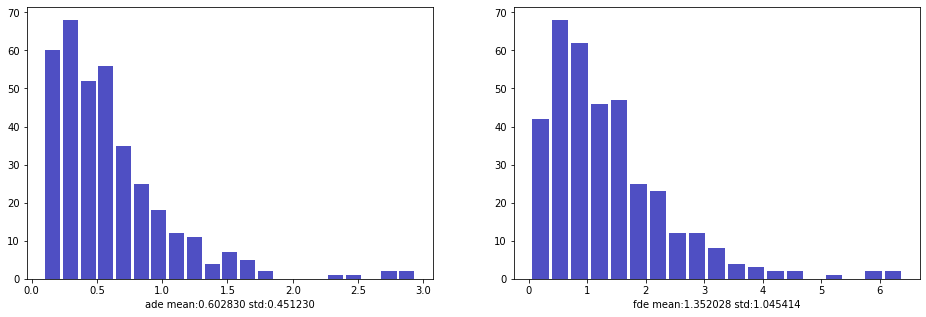

In [10]:
evaluator.hist()

### Evaluation for uncertainty

In [ ]:
import matplotlib.pyplot as plt

viz = SamplingVisualizer(N_future=4, N_history=history_traj_length, sample_size=1000)
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

for ax in axs:
    idx = np.random.randint(0, trajlets_for_testing.shape[0])
    traj = trajlets_for_testing[idx, :, :]
    viz.visualize_to_axis(ax, predictor, traj)
    ax.set_title(f"Index: {idx} ADE: {result['ade'][idx]:.2f} FDE: {result['fde'][idx]:.2f}")
#     ax.set_aspect(1)